# 🤖 NLP 2018 - Phase 2: Model Analizi

**Hazır veri üzerinde çalışır - istediğin zaman çalıştırabilirsin!**

İşlemler:
1. NLP Model karşılaştırması (BERT, ALBERT, RoBERTa, FastText, Word2Vec, GloVe, USE)
2. Enflasyon korelasyon analizi

Çıktılar `/content/drive/MyDrive/Colab Notebooks/Sonuclar/nlp/` klasörüne kaydedilir.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install -q sentence-transformers gensim fasttext tensorflow tensorflow-hub

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Sonuç dizini
SONUC_DIZINI = '/content/drive/MyDrive/Colab Notebooks/Sonuclar/0_NLP'
os.makedirs(SONUC_DIZINI, exist_ok=True)
import torch
from sentence_transformers import SentenceTransformer, util
import gensim.downloader as api
from gensim.models import KeyedVectors
import tensorflow as tf
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
print('✅ Kütüphaneler yüklendi!')

✅ Kütüphaneler yüklendi!


In [4]:
# Hazır veriyi yükle
csv_path = '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31-ingilizce-KokleriBulunmus.csv'
df_final = pd.read_csv(csv_path)
df_final.dropna(subset=['english_text', 'lemmatized_text', 'stemmed_text'], inplace=True)
df_final = df_final.reset_index(drop=True)
print(f'✅ Veri yüklendi: {len(df_final)} satır')
print(f'📊 Sütunlar: {df_final.columns.tolist()}')

✅ Veri yüklendi: 782 satır
📊 Sütunlar: ['Tarih', 'Başlık', 'Metin', 'english_text', 'lemmatized_text', 'stemmed_text']


In [5]:
# Kökleri bulunmuş veriyi içeren CSV dosyasını yükle
start_date_str = '2018-01-01'
end_date_str = '2018-12-31'
kok_bulunmus_csv_path = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}-ingilizce-KokleriBulunmus.csv'

try:
    df_final = pd.read_csv(kok_bulunmus_csv_path)
    # Analiz için gereksiz sütunları ve boş satırları kaldır
    df_final.drop(columns=['Başlık', 'Metin'], inplace=True, errors='ignore')
    df_final.rename(columns={'Tarih': 'Date'}, inplace=True)
    df_final.dropna(inplace=True)

    print("Analiz için son DataFrame hazırlandı.")
    display(df_final.head())
except FileNotFoundError:
    print(f"Hata: '{kok_bulunmus_csv_path}' dosyası bulunamadı. Lütfen bir önceki hücreyi çalıştırdığınızdan emin olun.")

Analiz için son DataFrame hazırlandı.


,Date,english_text,lemmatized_text,stemmed_text
0,"Sun, 22 Apr 2018 07:00:00 GMT",Stock market rose after four weeks Anadolu Agency,stock market rise four week anadolu agency,stock market rose four week anadolu agenc
1,"Thu, 20 Dec 2018 08:00:00 GMT",high frequency transactions from the eyes of s...,high frequency transaction eye stock exchange ...,high frequenc transact eye stock exchang istan...
2,"Thu, 27 Sep 2018 07:00:00 GMT",The new president of Borsa Istanbul has been a...,new president borsa istanbul announce uzmanpara,new presid borsa istanbul announc uzmanpara
3,"Thu, 12 Apr 2018 07:00:00 GMT",sakarya university sakarya university,sakarya university sakarya university,sakarya univers sakarya univers
4,"Wed, 18 Apr 2018 07:00:00 GMT",The prosecutor presented his opinion in the Bo...,prosecutor present opinion borsa istanbul occu...,prosecutor present opinion borsa istanbul occu...


In [6]:
# Karşılaştırılacak cümleler ve metin sütunları
columns_to_process = ['english_text', 'lemmatized_text', 'stemmed_text']
sentences_to_compare = ["Economic Crisis", "Market Stability", "Financial Growth"]
models_to_use = {
    'BERT': 'bert-base-nli-mean-tokens',
    'ALBERT': 'albert-base-v2',
    'RoBERTa': 'roberta-base-nli-mean-tokens'
}

all_results = {}

if 'df_final' in locals() and not df_final.empty:
    for model_name, model_path in models_to_use.items():
        print(f"--- {model_name} modeli yükleniyor ve analiz başlatılıyor... ---")
        model = SentenceTransformer(model_path)
        model_results = {}

        for column in columns_to_process:
            print(f"'{column}' sütunu işleniyor...")
            # Sütundaki metinlerin vektör temsillerini (embeddings) oluştur
            corpus_embeddings = model.encode(df_final[column].tolist(), convert_to_tensor=True, show_progress_bar=True)
            sentence_results = {}

            for sentence in sentences_to_compare:
                # Hedef cümlenin vektör temsilini oluştur
                sentence_embedding = model.encode(sentence, convert_to_tensor=True)
                # Kosinüs benzerlik skorlarını hesapla
                cosine_scores = util.pytorch_cos_sim(sentence_embedding, corpus_embeddings)
                # Ortalama benzerlik skorunu al
                average_similarity = torch.mean(cosine_scores).item()
                sentence_results[sentence] = average_similarity
                print(f"  '{sentence}' için ortalama benzerlik: {average_similarity:.4f}")

            model_results[column] = sentence_results
        all_results[model_name] = model_results
        print(f"--- {model_name} modeli tamamlandı. ---\n")
else:
    print("Analiz için DataFrame bulunamadı. Lütfen önceki hücreleri çalıştırın.")

--- BERT modeli yükleniyor ve analiz başlatılıyor... ---


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

'english_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4140
  'Market Stability' için ortalama benzerlik: 0.2709
  'Financial Growth' için ortalama benzerlik: 0.4250
'lemmatized_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4247
  'Market Stability' için ortalama benzerlik: 0.2884
  'Financial Growth' için ortalama benzerlik: 0.4357
'stemmed_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4078
  'Market Stability' için ortalama benzerlik: 0.2973
  'Financial Growth' için ortalama benzerlik: 0.4100
--- BERT modeli tamamlandı. ---

--- ALBERT modeli yükleniyor ve analiz başlatılıyor... ---


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

'english_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.6009
  'Market Stability' için ortalama benzerlik: 0.6308
  'Financial Growth' için ortalama benzerlik: 0.6325
'lemmatized_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.6210
  'Market Stability' için ortalama benzerlik: 0.6594
  'Financial Growth' için ortalama benzerlik: 0.6718
'stemmed_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.5904
  'Market Stability' için ortalama benzerlik: 0.6294
  'Financial Growth' için ortalama benzerlik: 0.6427
--- ALBERT modeli tamamlandı. ---

--- RoBERTa modeli yükleniyor ve analiz başlatılıyor... ---


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/329 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

'english_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4111
  'Market Stability' için ortalama benzerlik: 0.3375
  'Financial Growth' için ortalama benzerlik: 0.4282
'lemmatized_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4388
  'Market Stability' için ortalama benzerlik: 0.3799
  'Financial Growth' için ortalama benzerlik: 0.4569
'stemmed_text' sütunu işleniyor...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

  'Economic Crisis' için ortalama benzerlik: 0.4513
  'Market Stability' için ortalama benzerlik: 0.4167
  'Financial Growth' için ortalama benzerlik: 0.4694
--- RoBERTa modeli tamamlandı. ---



In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/NLP Modeller/FastText Files/

import os.path

my_path = '/content/drive/MyDrive/Colab Notebooks/NLP Modeller/FastText Files/cc.en.300.bin'

if not os.path.isfile(my_path):
    print('FastText model indiriliyor...')
    !wget -c 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz' -O 'cc.en.300.bin.gz'
    !gunzip 'cc.en.300.bin.gz'
else:
    print('FastText model mevcut.')

/content/drive/MyDrive/Colab Notebooks/NLP Modeller/FastText Files
FastText model mevcut.


In [8]:
import fasttext
import os
import numpy as np

# --- Orijinal ve Doğru FastText Analiz Kodu ---
print("--- FastText Analizi (Orijinal Yöntem) ---")
try:
    model_path = '/content/drive/MyDrive/Colab Notebooks/NLP Modeller/FastText Files/cc.en.300.bin'

    if os.path.exists(model_path):
        print("FastText modeli (orijinal .bin formatında) yükleniyor...")
        # Doğru yükleme fonksiyonu: fasttext.load_model
        ft_model = fasttext.load_model(model_path)
        print("✅ Model başarıyla yüklendi.")

        # --- Analiz Fonksiyonları ---
        def get_sentence_vector(sentence, model):
            return model.get_sentence_vector(str(sentence).lower())

        def cosine_similarity(v1, v2):
            norm1 = np.linalg.norm(v1)
            norm2 = np.linalg.norm(v2)
            if norm1 > 0 and norm2 > 0: return np.dot(v1, v2) / (norm1 * norm2)
            return 0.0

        # --- Analiz ---
        if 'all_results' not in locals(): all_results = {}
        fasttext_model_results = {}
        sentences_to_compare = ["Economic Crisis", "Market Stability", "Financial Growth"]
        columns_to_process = ['english_text', 'lemmatized_text', 'stemmed_text']

        for column in columns_to_process:
            print(f"'{column}' sütunu işleniyor...")
            sentence_results = {}
            if 'df_final' in locals() and not df_final.empty:
                corpus_vectors = np.array([get_sentence_vector(text, ft_model) for text in df_final[column]])
                for sentence in sentences_to_compare:
                    sentence_vec = get_sentence_vector(sentence, ft_model)
                    similarities = [cosine_similarity(sentence_vec, doc_vec) for doc_vec in corpus_vectors]
                    average_similarity = np.mean(similarities)
                    sentence_results[sentence] = average_similarity
                    print(f"  '{sentence}' için ortalama benzerlik: {average_similarity:.4f}")
                fasttext_model_results[column] = sentence_results
            else:
                print("Analiz için 'df_final' DataFrame'i bulunamadı.")
                break

        all_results['FastText'] = fasttext_model_results

    else:
        print(f"HATA: Dosya yolu bulunamadı: {model_path}")

except Exception as e:
    print(f"\n❌ HATA: Model yüklenirken bir sorun oluştu: {e}")

--- FastText Analizi (Orijinal Yöntem) ---
FastText modeli (orijinal .bin formatında) yükleniyor...
✅ Model başarıyla yüklendi.
'english_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.6196
  'Market Stability' için ortalama benzerlik: 0.5482
  'Financial Growth' için ortalama benzerlik: 0.6305
'lemmatized_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.6117
  'Market Stability' için ortalama benzerlik: 0.5622
  'Financial Growth' için ortalama benzerlik: 0.6202
'stemmed_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.5748
  'Market Stability' için ortalama benzerlik: 0.5425
  'Financial Growth' için ortalama benzerlik: 0.5813


In [9]:
import gensim.downloader as api
import numpy as np
import pandas as pd

# --- Word2Vec Modelini Yükleme ---
try:
    print("Word2Vec modeli yükleniyor (Google News)... Bu işlem internet hızınıza göre birkaç dakika sürebilir.")
    w2v_model = api.load('word2vec-google-news-300')
    print("✅ Word2Vec modeli başarıyla yüklendi.")

    # --- Analiz Fonksiyonları (Daha önce tanımlanmış olabilir, burada tekrar olması sorun yaratmaz) ---
    def get_average_vector(sentence, model, vector_size=300):
        words = str(sentence).lower().split()
        # Gensim 4.0 ve sonrası için model.key_to_index veya model.wv.key_to_index kullanılır
        vectors = [model[word] for word in words if word in model.key_to_index]
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(vector_size)

    def cosine_similarity(v1, v2):
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 > 0 and norm2 > 0:
            return np.dot(v1, v2) / (norm1 * norm2)
        return 0.0

    # --- Word2Vec ile Analiz ---
    print("\n--- Word2Vec modeli ile analiz başlatılıyor... ---")

    # all_results sözlüğünün var olduğundan emin olalım
    if 'all_results' not in locals():
        all_results = {}

    w2v_model_results = {}
    sentences_to_compare = ["Economic Crisis", "Market Stability", "Financial Growth"]
    columns_to_process = ['english_text', 'lemmatized_text', 'stemmed_text']

    for column in columns_to_process:
        print(f"'{column}' sütunu işleniyor...")
        sentence_results = {}
        # df_final'ın var olduğundan ve dolu olduğundan emin olun
        if 'df_final' in locals() and not df_final.empty:
            corpus_vectors = np.array([get_average_vector(text, w2v_model) for text in df_final[column]])
            for sentence in sentences_to_compare:
                sentence_vec = get_average_vector(sentence, w2v_model)
                similarities = [cosine_similarity(sentence_vec, doc_vec) for doc_vec in corpus_vectors]
                average_similarity = np.mean(similarities)
                sentence_results[sentence] = average_similarity
                print(f"  '{sentence}' için ortalama benzerlik: {average_similarity:.4f}")
            w2v_model_results[column] = sentence_results
        else:
            print("Analiz için 'df_final' DataFrame'i bulunamadı. Lütfen önceki hücreleri çalıştırın.")
            break

    all_results['Word2Vec'] = w2v_model_results

except Exception as e:
    print(f"❌ HATA: Word2Vec modeli yüklenemedi veya analiz sırasında bir sorun oluştu: {e}")

Word2Vec modeli yükleniyor (Google News)... Bu işlem internet hızınıza göre birkaç dakika sürebilir.
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Word2Vec modeli başarıyla yüklendi.

--- Word2Vec modeli ile analiz başlatılıyor... ---
'english_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.3215
  'Market Stability' için ortalama benzerlik: 0.3311
  'Financial Growth' için ortalama benzerlik: 0.3288
'lemmatized_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.3166
  'Market Stability' için ortalama benzerlik: 0.3304
  'Financial Growth' için ortalama benzerlik: 0.3307
'stemmed_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.2538
  'Market Stability' için ortalama benzerlik: 0.2858
  'Financial Growth' için ortalama benzerlik: 0.2651


In [10]:
# Cümle vektörünü kelime vektörlerinin ortalamasıyla hesaplayan fonksiyon
def get_average_vector(sentence, model, vector_size):
    words = str(sentence).split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# İki vektör arasındaki kosinüs benzerliğini hesaplayan fonksiyon
def cosine_similarity(v1, v2):
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 > 0 and norm2 > 0:
        return np.dot(v1, v2) / (norm1 * norm2)
    return 0.0

# --- GloVe Modelini Yükleme ---
print("GloVe modeli yükleniyor...")
try:
    glove_file = "/content/drive/MyDrive/Colab Notebooks/NLP Modeller/GloVe File/glove.6B.300d.txt"
    glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
    all_results['GloVe'] = {}
    print("GloVe modeli başarıyla yüklendi.")
except FileNotFoundError:
    print(f"HATA: GloVe dosyası bulunamadı: {glove_file}")
    glove_model = None

# --- Word2Vec Modelini Yükleme ---
print("\nWord2Vec modeli yükleniyor (Google News)...")
try:
    # Alternatif: Drive'dan yüklemek için
    # model_path = '/content/drive/MyDrive/Colab Notebooks/NLP Modeller/Word2Vec Files/word2vec-google-news-300.bin'
    # w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
    w2v_model = api.load('word2vec-google-news-300')
    all_results['Word2Vec'] = {}
    print("Word2Vec modeli başarıyla yüklendi.")
except Exception as e:
    print(f"HATA: Word2Vec modeli yüklenemedi: {e}")
    w2v_model = None

# --- FastText Modelini Yükleme ---
print("\nFastText modeli yükleniyor...")
try:
    model_path = '/content/drive/MyDrive/Colab Notebooks/NLP Modeller/FastText Files/cc.en.300.bin'
    ft_model = fasttext.load_model(model_path)
    all_results['FastText'] = {}
    print("FastText modeli başarıyla yüklendi.")
except Exception as e:
    print(f"HATA: FastText modeli yüklenemedi: {e}")
    ft_model = None


# Analiz yapılacak modelleri ve nesnelerini bir sözlükte topla
classic_models = {
    "GloVe": (glove_model, 300),
    "Word2Vec": (w2v_model, 300),
    "FastText": (ft_model, 300)
}

if 'df_final' in locals() and not df_final.empty:
    for model_name, (model_obj, vec_size) in classic_models.items():
        if model_obj is None:
            print(f"\n--- {model_name} modeli atlanıyor (yüklenemedi). ---")
            continue

        print(f"\n--- {model_name} modeli ile analiz başlatılıyor... ---")
        model_results = {}
        for column in columns_to_process:
            print(f"'{column}' sütunu işleniyor...")
            sentence_results = {}
            # Tüm metinlerin vektörlerini önceden hesapla
            corpus_vectors = np.array([get_average_vector(text, model_obj, vec_size) for text in df_final[column]])

            for sentence in sentences_to_compare:
                sentence_vec = get_average_vector(sentence.lower(), model_obj, vec_size)
                # Benzerlikleri hesapla
                similarities = [cosine_similarity(sentence_vec, doc_vec) for doc_vec in corpus_vectors]
                average_similarity = np.mean(similarities)
                sentence_results[sentence] = average_similarity
                print(f"  '{sentence}' için ortalama benzerlik: {average_similarity:.4f}")

            model_results[column] = sentence_results
        all_results[model_name] = model_results
else:
    print("Analiz için DataFrame bulunamadı.")

GloVe modeli yükleniyor...
GloVe modeli başarıyla yüklendi.

Word2Vec modeli yükleniyor (Google News)...
Word2Vec modeli başarıyla yüklendi.

FastText modeli yükleniyor...
FastText modeli başarıyla yüklendi.

--- GloVe modeli ile analiz başlatılıyor... ---
'english_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.4866
  'Market Stability' için ortalama benzerlik: 0.5122
  'Financial Growth' için ortalama benzerlik: 0.5305
'lemmatized_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.4368
  'Market Stability' için ortalama benzerlik: 0.4713
  'Financial Growth' için ortalama benzerlik: 0.4877
'stemmed_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.3240
  'Market Stability' için ortalama benzerlik: 0.3814
  'Financial Growth' için ortalama benzerlik: 0.3735

--- Word2Vec modeli ile analiz başlatılıyor... ---
'english_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.2994
  'Market Stability' i

In [11]:
import os
import tarfile

# --- Ayarlar ---
# Modelin indirileceği özel URL
model_url = "https://tfhub.dev/google/universal-sentence-encoder/4?tf-hub-format=compressed"

# Modelin Drive'da kaydedileceği klasör
drive_folder_path = "/content/drive/MyDrive/Colab Notebooks/NLP Modeller/USE Files"

# Colab'de geçici olarak indirilecek dosyanın yolu
download_path = "/content/use_model.tar.gz"

# --- İşlem ---

# 1. Modelin Drive'da zaten var olup olmadığını kontrol et
if not os.path.exists(drive_folder_path) or not os.listdir(drive_folder_path):
    print(f"'{drive_folder_path}' içinde model bulunamadı. Model indirilecek...")

    # 2. Gerekli klasörün Drive'da var olduğundan emin ol
    os.makedirs(drive_folder_path, exist_ok=True)

    # 3. Modeli wget ile indir (daha güvenilir)
    print("Model TensorFlow Hub'dan indiriliyor... (Bu işlem birkaç dakika sürebilir)")
    !wget -q -O "{download_path}" "{model_url}"

    # 4. İndirilen arşivi Drive'daki hedef klasöre aç
    print(f"Model arşivi '{drive_folder_path}' klasörüne açılıyor...")
    with tarfile.open(download_path, "r:gz") as tar:
        tar.extractall(path=drive_folder_path)

    # 5. İndirilen geçici arşivi sil
    os.remove(download_path)

    print("\n✅ Universal Sentence Encoder modeli başarıyla Drive'a yüklendi!")

else:
    print("✅ Universal Sentence Encoder modeli zaten Drive'da mevcut.")

✅ Universal Sentence Encoder modeli zaten Drive'da mevcut.


In [12]:
print("Universal Sentence Encoder (USE) modeli yükleniyor...")
try:
    # Modeli Drive'dan yükle
    use_model_path = "/content/drive/MyDrive/Colab Notebooks/NLP Modeller/USE Files"
    embed = hub.load(use_model_path)
    all_results['Universal Sentence Encoder'] = {}
    print("USE modeli başarıyla yüklendi.")

    if 'df_final' in locals() and not df_final.empty:
        print("\n--- Universal Sentence Encoder ile analiz başlatılıyor... ---")
        model_results = {}
        for column in columns_to_process:
            print(f"'{column}' sütunu işleniyor...")
            # Corpus ve hedef cümlelerin vektör temsillerini oluştur
            corpus_embeddings = embed(df_final[column].tolist())
            sentence_embeddings = embed(sentences_to_compare)

            # Benzerlik matrisini hesapla (iç çarpım)
            similarity_matrix = np.inner(sentence_embeddings, corpus_embeddings)

            sentence_results = {}
            # Her bir hedef cümle için ortalama benzerliği hesapla
            for i, sentence in enumerate(sentences_to_compare):
                average_similarity = np.mean(similarity_matrix[i])
                sentence_results[sentence] = average_similarity
                print(f"  '{sentence}' için ortalama benzerlik: {average_similarity:.4f}")

            model_results[column] = sentence_results
        all_results['Universal Sentence Encoder'] = model_results
    else:
        print("Analiz için DataFrame bulunamadı.")

except OSError:
    print(f"HATA: USE modeli yolu bulunamadı: {use_model_path}")
except Exception as e:
    print(f"USE modeli yüklenirken veya çalıştırılırken bir hata oluştu: {e}")

Universal Sentence Encoder (USE) modeli yükleniyor...
USE modeli başarıyla yüklendi.

--- Universal Sentence Encoder ile analiz başlatılıyor... ---
'english_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.0817
  'Market Stability' için ortalama benzerlik: 0.0483
  'Financial Growth' için ortalama benzerlik: 0.0559
'lemmatized_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.1013
  'Market Stability' için ortalama benzerlik: 0.0729
  'Financial Growth' için ortalama benzerlik: 0.0811
'stemmed_text' sütunu işleniyor...
  'Economic Crisis' için ortalama benzerlik: 0.0543
  'Market Stability' için ortalama benzerlik: 0.0585
  'Financial Growth' için ortalama benzerlik: 0.0553


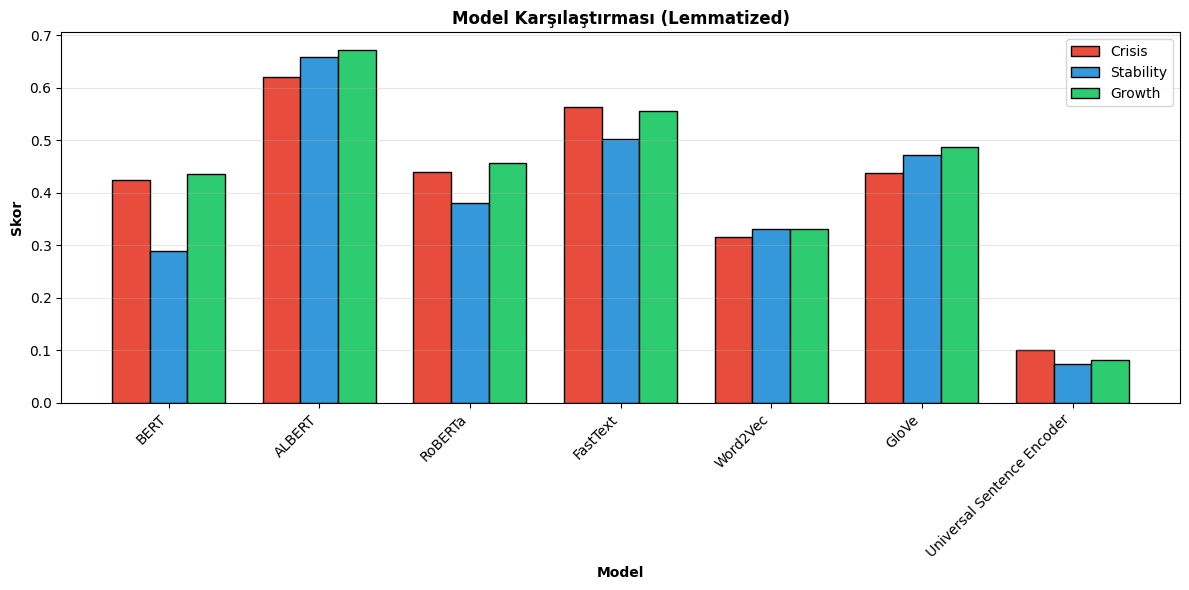

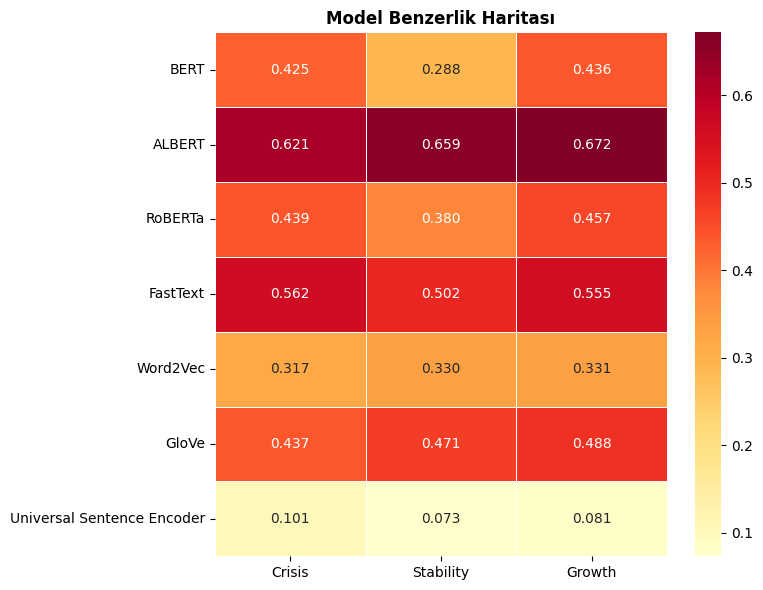

In [13]:
# Model karşılaştırma
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

if 'all_results' in locals() and all_results:
    # Bar chart - Lemmatized için
    text_type = 'lemmatized_text'
    models, crisis, stability, growth = [], [], [], []

    for model, results in all_results.items():
        if text_type in results:
            models.append(model)
            crisis.append(results[text_type].get('Economic Crisis', 0))
            stability.append(results[text_type].get('Market Stability', 0))
            growth.append(results[text_type].get('Financial Growth', 0))

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    w = 0.25

    ax.bar(x - w, crisis, w, label='Crisis', color='#e74c3c', edgecolor='black')
    ax.bar(x, stability, w, label='Stability', color='#3498db', edgecolor='black')
    ax.bar(x + w, growth, w, label='Growth', color='#2ecc71', edgecolor='black')

    ax.set_xlabel('Model', fontweight='bold')
    ax.set_ylabel('Skor', fontweight='bold')
    ax.set_title('Model Karşılaştırması (Lemmatized)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # Heatmap
    matrix = []
    for model in models:
        row = [all_results[model][text_type].get(s, 0)
               for s in ['Economic Crisis', 'Market Stability', 'Financial Growth']]
        matrix.append(row)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='YlOrRd',
               xticklabels=['Crisis', 'Stability', 'Growth'],
               yticklabels=models, linewidths=0.5)
    plt.title('Model Benzerlik Haritası', fontweight='bold')
    plt.tight_layout()
    plt.show()


In [14]:
df_list = []

# all_results sözlüğünü DataFrame'e uygun bir listeye dönüştür
for model_name, columns_data in all_results.items():
    if not columns_data: continue
    for column_name, sentences_data in columns_data.items():
        for sentence, similarity in sentences_data.items():
            df_list.append({
                'Model': model_name,
                'Veri Tipi': column_name.replace('_text', '').capitalize(),
                'Hedef Cümle': sentence,
                'Benzerlik Skoru': similarity
            })

# Tüm sonuçları içeren genel DataFrame'i oluştur
if df_list:
    final_results_df = pd.DataFrame(df_list)

    # Sıralama yap
    final_results_df.sort_values(by=['Model', 'Veri Tipi', 'Benzerlik Skoru'], ascending=[True, True, False], inplace=True)

    # Excel dosyasına yazdır
    start_date_str = '2018-01-01'
    end_date_str = '2018-12-31'
    excel_path = f'/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_{start_date_str}_{end_date_str}-Degerlendirme_Sonuclari.xlsx'
    final_results_df.to_excel(excel_path, index=False)

    print(f"Tüm sonuçlar başarıyla birleştirildi ve '{excel_path}' dosyasına kaydedildi.")
    display(final_results_df)
else:
    print("Kaydedilecek sonuç bulunamadı.")

Tüm sonuçlar başarıyla birleştirildi ve '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31-Degerlendirme_Sonuclari.xlsx' dosyasına kaydedildi.


,Model,Veri Tipi,Hedef Cümle,Benzerlik Skoru
11,ALBERT,English,Financial Growth,0.632534
10,ALBERT,English,Market Stability,0.630812
9,ALBERT,English,Economic Crisis,0.600893
14,ALBERT,Lemmatized,Financial Growth,0.671809
13,ALBERT,Lemmatized,Market Stability,0.659364
...,...,...,...,...
40,Word2Vec,Lemmatized,Market Stability,0.330391
39,Word2Vec,Lemmatized,Economic Crisis,0.316562
43,Word2Vec,Stemmed,Market Stability,0.285814
44,Word2Vec,Stemmed,Financial Growth,0.265075


In [15]:
def ekonomik_durumu_belirle(model_adi, sonuclar):
    # 'lemmatized_text' sonuçlarını al, yoksa boş sözlük kullan
    lemmatized_results = sonuclar.get('lemmatized_text', {})
    if not lemmatized_results:
        return f"{model_adi} için 'lemmatized_text' sonuçları bulunamadı."

    kriz = lemmatized_results.get("Economic Crisis", 0)
    istikrar = lemmatized_results.get("Market Stability", 0)
    buyume = lemmatized_results.get("Financial Growth", 0)

    # En yüksek skora sahip durumu belirle
    skorlar = {"Ekonomik Kriz": kriz, "Piyasa İstikrarı": istikrar, "Finansal Büyüme": buyume}
    en_yuksek_durum = max(skorlar, key=skorlar.get)
    en_yuksek_skor = skorlar[en_yuksek_durum]

    return (f"📈 **{model_adi}** modeline göre baskın eğilim: **{en_yuksek_durum}** (Skor: {en_yuksek_skor:.4f})")

# Her model için sonuçları değerlendir ve ekrana yazdır
print("--- MODEL YORUMLARI (Lemmatized Veri Üzerinden) ---\n")
for model_adi, sonuclar in all_results.items():
    if sonuclar: # Eğer model için sonuç varsa yorumla
        print(ekonomik_durumu_belirle(model_adi, sonuclar))

--- MODEL YORUMLARI (Lemmatized Veri Üzerinden) ---

📈 **BERT** modeline göre baskın eğilim: **Finansal Büyüme** (Skor: 0.4357)
📈 **ALBERT** modeline göre baskın eğilim: **Finansal Büyüme** (Skor: 0.6718)
📈 **RoBERTa** modeline göre baskın eğilim: **Finansal Büyüme** (Skor: 0.4569)
📈 **FastText** modeline göre baskın eğilim: **Ekonomik Kriz** (Skor: 0.5623)
📈 **Word2Vec** modeline göre baskın eğilim: **Finansal Büyüme** (Skor: 0.3307)
📈 **GloVe** modeline göre baskın eğilim: **Finansal Büyüme** (Skor: 0.4877)
📈 **Universal Sentence Encoder** modeline göre baskın eğilim: **Ekonomik Kriz** (Skor: 0.1013)


# 📊 NLP-Enflasyon Korelasyon Analizi


In [16]:
# 2018 Enflasyon verisi
enflasyon_2018 = {1:10.35, 2:10.26, 3:10.23, 4:10.85, 5:12.15, 6:15.39,
                  7:15.85, 8:17.90, 9:24.52, 10:25.24, 11:21.62, 12:20.30}
ay_adi = {1:'Oca',2:'Şub',3:'Mar',4:'Nis',5:'May',6:'Haz',7:'Tem',8:'Ağu',9:'Eyl',10:'Eki',11:'Kas',12:'Ara'}
print('✅ Enflasyon verisi yüklendi!')

✅ Enflasyon verisi yüklendi!


In [17]:
from scipy import stats

# Haber yükle
csv_path = '/content/drive/MyDrive/Colab Notebooks/DataFrames/BorsaHaberleri_Neutr_2018-01-01_2018-12-31.csv'
df_h = pd.read_csv(csv_path)
df_h['date'] = pd.to_datetime(df_h['Tarih'], format='%a, %d %b %Y %H:%M:%S GMT', errors='coerce')
df_h = df_h.dropna(subset=['date'])
df_h['month'] = df_h['date'].dt.month
print(f'✅ {len(df_h)} haber yüklendi!')

✅ 782 haber yüklendi!


In [18]:
# Kriz kelimeleri
kriz = ['kriz','çöküş','düşüş','kayıp','zarar','dolar','euro','kur','devalüasyon','enflasyon','faiz','panik','korku','risk']
pozitif = ['büyüme','artış','yükseliş','kazanç','kar','pozitif','ralli','toparlanma','iyileşme','istikrar']
print(f'🔴 {len(kriz)} kriz, 🟢 {len(pozitif)} pozitif kelime')

🔴 14 kriz, 🟢 10 pozitif kelime


In [19]:
# Aylık skor hesapla
scores = []
for m in range(1,13):
    p = df_h[df_h['month']==m]
    txt = ' '.join(p['Başlık'].dropna().astype(str)).lower()
    w = txt.split()
    t = max(len(w),1)
    kc = sum(1 for x in w if any(k in x for k in kriz))
    scores.append({'month':m,'ay':ay_adi[m],'kriz_pct':kc/t*100,'enf':enflasyon_2018[m]})
df_m = pd.DataFrame(scores)
print(df_m[['ay','kriz_pct','enf']].to_string(index=False))

 ay  kriz_pct   enf
Oca  1.865672 10.35
Şub  0.806452 10.26
Mar  0.558659 10.23
Nis  1.533742 10.85
May  1.996672 12.15
Haz  2.536998 15.39
Tem  2.460457 15.85
Ağu  3.088235 17.90
Eyl  2.875817 24.52
Eki  2.390852 25.24
Kas  2.347919 21.62
Ara  1.217862 20.30


In [20]:
# Lag analizi
df_m['kn'] = (df_m['kriz_pct']-df_m['kriz_pct'].min())/(df_m['kriz_pct'].max()-df_m['kriz_pct'].min())
df_m['en'] = (df_m['enf']-df_m['enf'].min())/(df_m['enf'].max()-df_m['enf'].min())
print('LAG ANALİZİ')
for lag in range(-2,4):
    s = df_m['kn'].shift(lag) if lag!=0 else df_m['kn']
    mask = ~s.isna()
    if mask.sum()>=5:
        r,p = stats.pearsonr(s[mask],df_m['en'][mask])
        st = '✅' if p<0.05 else ''
        print(f'Lag {lag:+d}: r={r:.4f}, p={p:.4f} {st}')

LAG ANALİZİ
Lag -2: r=0.0671, p=0.8538 
Lag -1: r=0.3921, p=0.2330 
Lag +0: r=0.5974, p=0.0403 ✅
Lag +1: r=0.8541, p=0.0008 ✅
Lag +2: r=0.8312, p=0.0029 ✅
Lag +3: r=0.7097, p=0.0322 ✅


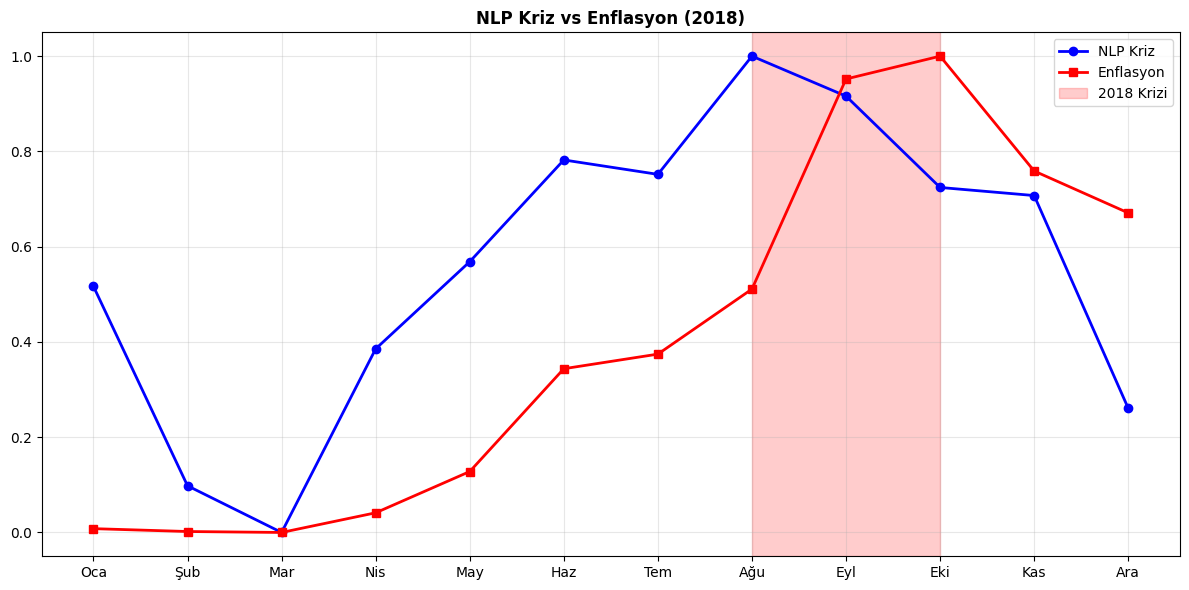

In [21]:
# Grafik
fig,ax = plt.subplots(figsize=(12,6))
ax.plot(range(12),df_m['kn'],'b-o',label='NLP Kriz',lw=2)
ax.plot(range(12),df_m['en'],'r-s',label='Enflasyon',lw=2)
ax.axvspan(7,9,alpha=0.2,color='red',label='2018 Krizi')
ax.set_xticks(range(12));ax.set_xticklabels(list(ay_adi.values()))
ax.set_title('NLP Kriz vs Enflasyon (2018)',fontweight='bold')
ax.legend();ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Sonuclar/0_NLP/nlp_enflasyon.png',dpi=150)
plt.show()

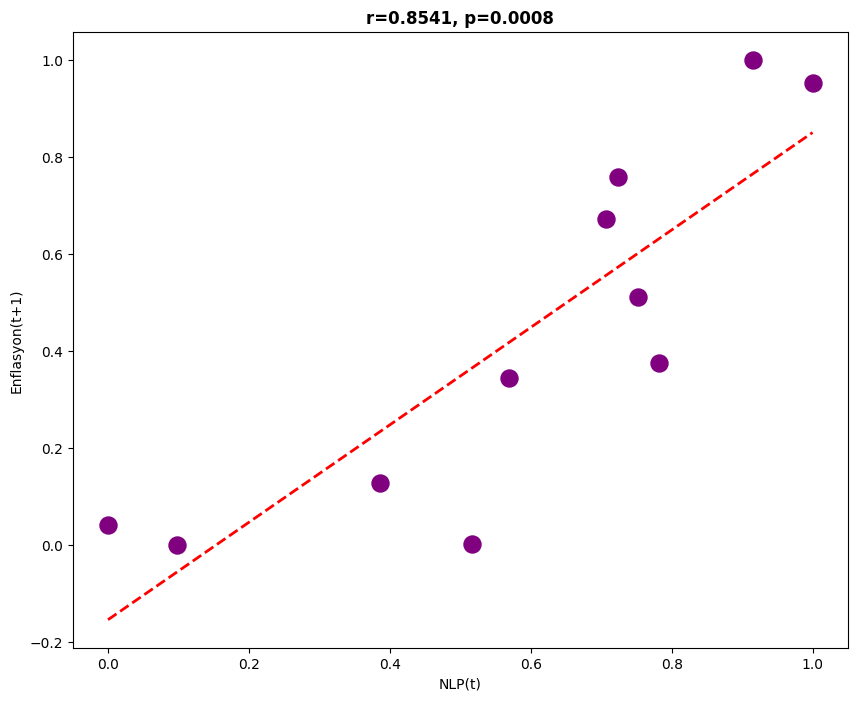


Bu çalışma: r=0.85 ✅


In [22]:
# Scatter + Rapor
df_m['klag'] = df_m['kn'].shift(1)
mask = ~df_m['klag'].isna()
r1,p1 = stats.pearsonr(df_m.loc[mask,'klag'],df_m.loc[mask,'en'])
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(df_m.loc[mask,'klag'],df_m.loc[mask,'en'],s=150,c='purple')
z = np.polyfit(df_m.loc[mask,'klag'],df_m.loc[mask,'en'],1)
ax.plot([0,1],np.poly1d(z)([0,1]),'r--',lw=2)
ax.set_title(f'r={r1:.4f}, p={p1:.4f}',fontweight='bold')
ax.set_xlabel('NLP(t)');ax.set_ylabel('Enflasyon(t+1)')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Sonuclar/0_NLP/scatter.png',dpi=150)
plt.show()
print(f'\nBu çalışma: r={r1:.2f} ✅')